## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from IPython import display
import PIL
import glob
import imageio
import numpy as np
import cv2

## 导入数据

In [2]:
data_path = 'F:/ipython_notebook/tensorflow_gan_gcgan_faces/data/faces'

def get_image_paths(directory):
    return [x.path for x in os.scandir(directory) if x.name.endswith(".jpg") or x.name.endswith(".png")]

images_path = get_image_paths(data_path)
print(images_path[0])
print(len(images_path))

F:/ipython_notebook/tensorflow_gan_gcgan_faces/data/faces\0000fdee4208b8b7e12074c920bc6166-0.jpg
51223


In [3]:
def load_images(image_paths):
    iter_all_images = (cv2.imread(fn) for fn in image_paths)
    for i, image in enumerate(iter_all_images):
        if i == 0:
            all_images = np.empty((len(image_paths),) + image.shape, dtype=image.dtype)
        all_images[i] = image
    return all_images

images_data = load_images(images_path[:2000])
print(images_data.shape)
print(images_data.shape[0])

(2000, 96, 96, 3)
2000


## 可视化数据

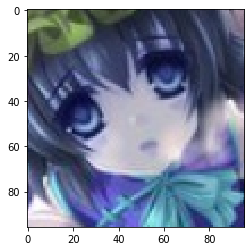

In [4]:
plt.imshow(images_data[0])

## tf封装数据

[[[-0.16078432 -0.08235294 -0.31764707]
  [-0.14509805 -0.06666667 -0.3019608 ]
  [-0.19215687 -0.11372549 -0.34901962]
  ...
  [ 0.24705882  0.09803922  0.24705882]
  [ 0.22352941  0.06666667  0.21568628]
  [ 0.29411766  0.13725491  0.28627452]]

 [[-0.12941177 -0.04313726 -0.29411766]
  [-0.19215687 -0.10588235 -0.35686275]
  [-0.25490198 -0.16862746 -0.41960785]
  ...
  [ 0.23137255  0.08235294  0.23137255]
  [ 0.2784314   0.12156863  0.27058825]
  [ 0.23137255  0.07450981  0.22352941]]

 [[-0.15294118 -0.05098039 -0.34901962]
  [-0.29411766 -0.2        -0.48235294]
  [-0.38039216 -0.27058825 -0.5529412 ]
  ...
  [ 0.19215687  0.04313726  0.19215687]
  [ 0.22352941  0.06666667  0.21568628]
  [ 0.13725491 -0.01960784  0.12941177]]

 ...

 [[ 0.7254902   0.654902    0.75686276]
  [ 0.70980394  0.6313726   0.73333335]
  [ 0.7490196   0.6392157   0.73333335]
  ...
  [-0.654902   -0.64705884 -0.11372549]
  [-0.6313726  -0.6313726  -0.08235294]
  [-0.6784314  -0.6862745  -0.12156863]]

 [

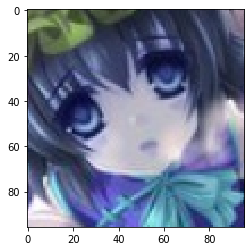

In [5]:
BUFFER_SIZE = 2000
BATCH_SIZE = 32

train_images = images_data.reshape(images_data.shape[0], 96, 96, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_images[0])
plt.imshow(images_data[0])

## 定义生成模型

In [6]:
def make_generator_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(24*24*768, use_bias=False, input_shape=(100,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
 
    model.add(keras.layers.Reshape((24, 24, 768)))
 
    model.add(keras.layers.Conv2DTranspose(384, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
 
    model.add(keras.layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
 
    model.add(keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
 
    return model

## 测试生成模型

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 442368)            44236800  
_________________________________________________________________
batch_normalization (BatchNo (None, 442368)            1769472   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 442368)            0         
_________________________________________________________________
reshape (Reshape)            (None, 24, 24, 768)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 24, 24, 384)       7372800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 384)       1536      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 384)       0

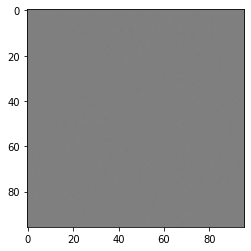

In [7]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image)
plt.imshow((generated_image[0, :, :, :]*127.5+127.5)/255.)

## 定义鉴别模型

In [8]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(192, (5, 5), strides=(2, 2), padding='same', input_shape=[96, 96, 3]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
      
    model.add(keras.layers.Conv2D(384, (5, 5), strides=(2, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))
       
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))
     
    return model

## 测试鉴别模型

In [9]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)

print (decision)

tf.Tensor([[2.6441023e-05]], shape=(1, 1), dtype=float32)


## 定义损失优化函数和callbacks

In [10]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_faces_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 设置超参

In [11]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

## 定义梯度下降 

In [12]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
 
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## 定义训练过程及保存训练图片

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5)/255.)
        plt.axis('off') 
    plt.savefig('./save_iamge/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## 开始训练

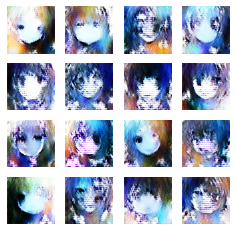

Wall time: 1h 58min 7s


In [14]:
%%time
train(train_dataset, EPOCHS)

## 展示最后一次训练结果

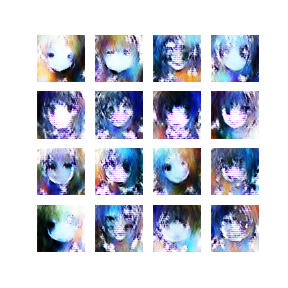

In [15]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
def display_image(epoch_no):
    return PIL.Image.open('./save_image/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

## 把训练过程图片变成gif动图 

In [16]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
os.rename('./save_image/dcgan.gif', './save_image/dcgan.gif.png')

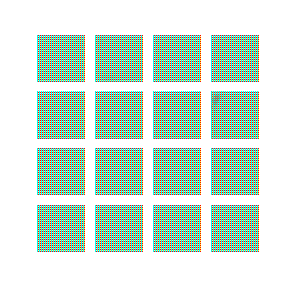

In [17]:
display.Image(filename="./save_iamge/dcgan.gif.png")

## 保存模型

In [18]:
generator.save('./save_model/model.h5')